# 0. Set Up

In [1]:
# Librerias
!git clone https://github.com/domingomery/balu3
!pip install ./balu3

fatal: destination path 'balu3' already exists and is not an empty directory.
Processing ./balu3
  Preparing metadata (setup.py) ... done
  Created wheel for balu3: filename=balu3-1.0-py3-none-any.whl size=43701 sha256=fb8bf2a705ab26948ca8690635c61aac2718f728304069144222da7ddebaa642
  Stored in directory: /tmp/pip-ephem-wheel-cache-svnfcgx3/wheels/9e/f6/a9/3d39da83a3504331129d706f5b04ceb3dbf0ec0f313cdb8fcf
Successfully built balu3
  Attempting uninstall: balu3
    Found existing installation: balu3 1.0
    Uninstalling balu3-1.0:
      Successfully uninstalled balu3-1.0


In [2]:
# Numpy & Maplotlib
import numpy             as np
import matplotlib.pyplot as plt
import cv2


# Balu
from   balu3.ft.norm     import minmax
from   balu3.fx.chr      import lbp, haralick, gabor, hog, basicint, contrast, clp
from   balu3.fs.sel      import jfisher
from   balu3.fs.sel      import sfs, exsearch, clean
from   balu3.fx.geo      import basicgeo,fitellipse,hugeo,flusser,gupta
from   tqdm.auto         import tqdm
from   balu3.im.proc import im_grad,fspecial,gradlog
from   balu3.ft.trans  import pca

# Sklearn
from sklearn.metrics   import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid # KNN y DMin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA

from sklearn.naive_bayes import GaussianNB  # Naive Bayer
from sklearn.base import BaseEstimator, ClassifierMixin # Bayes KDE
from sklearn.neighbors import KernelDensity

from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.linear_model import LogisticRegression # Regresion logistica
from sklearn.neural_network import MLPClassifier # NN
from sklearn.svm import SVC # SVM

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectFromModel


from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

from   sklearn.model_selection import train_test_split


# 1. Image Loading

In [3]:
!wget https://www.dropbox.com/scl/fi/1egkpx414yen4affvczw9/jaffec.zip?rlkey=txhzx69hg0wh2xklmg3oc1u6t
!mv jaffec.zip?rlkey=txhzx69hg0wh2xklmg3oc1u6t jaffec.zip
!unzip -qq jaffec.zip

--2024-06-13 22:55:40--  https://www.dropbox.com/scl/fi/1egkpx414yen4affvczw9/jaffec.zip?rlkey=txhzx69hg0wh2xklmg3oc1u6t
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4f660fcf882877de620d0c9bc7.dl.dropboxusercontent.com/cd/0/inline/CUyNHC0UuWvB4sJ28Om95JZdysKm7u2LV3kbdHFNbSSI0o6hzUtc856K9aR3_CMhGKIaF8qR18bffXUSx3GiJVjHF9hQcrYwXIQdjPGFjZRWiREskSQTnbZPrs61meKX3tc/file# [following]
--2024-06-13 22:55:40--  https://uc4f660fcf882877de620d0c9bc7.dl.dropboxusercontent.com/cd/0/inline/CUyNHC0UuWvB4sJ28Om95JZdysKm7u2LV3kbdHFNbSSI0o6hzUtc856K9aR3_CMhGKIaF8qR18bffXUSx3GiJVjHF9hQcrYwXIQdjPGFjZRWiREskSQTnbZPrs61meKX3tc/file
Resolving uc4f660fcf882877de620d0c9bc7.dl.dropboxusercontent.com (uc4f660fcf882877de620d0c9bc7.dl.dropboxusercontent.com)... 162.125.4.15, 2620:100:6019:15::a27d:40f
Connecting to uc4f660fc

In [4]:
def num2fixstr(x: int, d: int) -> str:
    """
    Transforma en un string un numero x en una cantidad de x digitos
    """
    string = '%0*d' % (d, x)
    return string

def get_image_path(num_class: int, num_img: int, sep='_') -> str:
    """
    Retorna la ruta de la imagen a cargar dada una clase num_class y un
    identificador de imagen num_img
    """

    FPATH = 'jaffec'
    PREFIX = 'face'
    img_class = num2fixstr(num_class, 3)
    img_num = num2fixstr(num_img, 5)
    img_path = f'{FPATH}/{PREFIX}_{img_class}_{img_num}.png'

    return img_path

def imageload(num_class: int, num_img: int, echo='off') -> str:
    """
    Carga la imagen
    """
    path = get_image_path(num_class, num_img)
    if echo == 'on':
        print(f'loading image {path} ...')
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    return img

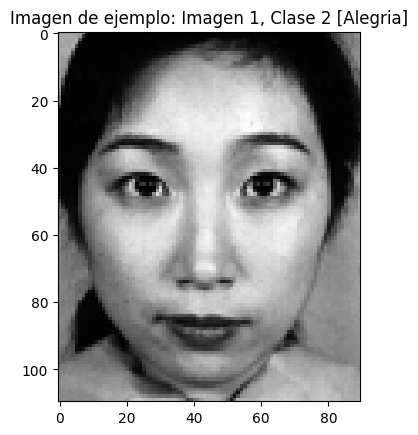

In [5]:
test_img = imageload(1,1)
plt.title('Imagen de ejemplo: Imagen 1, Clase 2 [Alegria]')
plt.imshow(test_img, cmap='gray')
plt.show()

# 2. Image Preprocessing [TODO]

# 3. Feature Extraction


In [6]:
K = 7 # Cantidad de clases del dataset
N = 30 # Cantidad de imagenes por clase
y = np.zeros((K * N), 'int') # Vector de clasificacion


# ------------------------------- LBP ------------------------------------------
hdiv_0 = 1 # LBP con 8x8 particiones
vdiv_0 = 1
Mlbp = 10 * hdiv_0 * vdiv_0 # Numero de elementos vector LBP
Xlbp = np.zeros((K * N, Mlbp)) # Matriz de caracteristicas para descriptor LBP


# ----------------------------- HARALICK ---------------------------------------
Mhar = 24 # Numero de elmeentos vector Haralick para distancia = 1
Xhar = np.zeros((K * N, Mhar)) # Matriz de caracteristicas de Haralick
d_0 = 1 # Parametro de distancia

# ------------------------------- Hog ------------------------------------------
hog_orientations = 9
px_0 = 64 # Parametro pixeles por bloque: 64 pixeles por bloque
cl_0 = 1 # Parametro celdas por bloque: 2 celdas por bloque
bn = 9 # Numero de bins del descriptor Hog.
Mhog = 9 # Numero de elementos en total del vector descriptor
Xhog = np.zeros((K * N, Mhog)) # Matriz  de caracteristicas para descriptor Hog


# ------------------------------- Gabor ----------------------------------------
rotations_0 = 8 # 8 rotaciones
dilations_0 = 8 # 8 escalas
Mgab = rotations_0 * dilations_0 + 3 # Numero de elementos vector de Gabor para 8 rotaciones y escalas
Xgab = np.zeros((K * N, Mgab))


In [7]:

t = 0
# sc: Selected Channel (SC)
# Inicializamos una matriz de caracteristicas para cada canal.
Xlbp = np.zeros((K * N, Mlbp))
Xhar = np.zeros((K * N, Mhar))
Xhog = np.zeros((K * N, Mhog))
Xgab = np.zeros((K * N, Mgab))

print(f' Extracting features ... '.center(100, '*'))

for k in range(K): # Por cada clase ...
    print(f'Extracting features: batch {k + 1}/7')

    for i in tqdm(range(N)): # Por cada imagen ...
        num_class = k + 1
        num_img = i + 1
        # Cargamos la i-esima imagen de la k-esima clase
        img = 255*imageload(num_class, num_img)
        # Preprocesamos la imagen para eliminar ruido y resaltar el lunar

        # LBP con 1x1 particiones
        Xlbp[t,:] = lbp(img, hdiv=hdiv_0, vdiv=vdiv_0,
                            mapping='uniform', norm=True)

        # Haralick con d=1 pixeles
        Xhar[t,:] = haralick(img, distance=d_0)

        # Hog con 9 orientaciones
        Xhog[t,:] = hog(img, orientations=hog_orientations,
                            cells_per_block=(cl_0, cl_0),
                            pixels_per_cell=(px_0, px_0),
                            norm=False)
        # Gabor
        Xgab[t,:] = gabor(img,
                              dilations=dilations_0,
                              rotations=rotations_0)

        # Vector de clasificacion
        y[t] = k + 1 # Deberia ser el mismo para los 3 canales.
        t = t + 1

************************************* Extracting features ... **************************************
Extracting features: batch 1/7


  0%|          | 0/30 [00:00<?, ?it/s]

Extracting features: batch 2/7


  0%|          | 0/30 [00:00<?, ?it/s]

Extracting features: batch 3/7


  0%|          | 0/30 [00:00<?, ?it/s]

Extracting features: batch 4/7


  0%|          | 0/30 [00:00<?, ?it/s]

Extracting features: batch 5/7


  0%|          | 0/30 [00:00<?, ?it/s]

Extracting features: batch 6/7


  0%|          | 0/30 [00:00<?, ?it/s]

Extracting features: batch 7/7


  0%|          | 0/30 [00:00<?, ?it/s]

In [8]:
X = np.concatenate((Xlbp, Xhar, Xhog, Xgab), axis=1)

# 4. Leave One Person Out

In [9]:
def split_train_test_val(X, y, i):
  """
  Input: Matriz de caracteristicas X y vector de clases y
  Output: Conjuntos training, testing y validation.
  """
  # i: i-esima mujer
  W = 10
  K = np.max(y) # Cantidad de clases = 7
  N = X.shape[0] // K # Numero de muestras por clase = 30
  N_test = (N // W) * K # numero de muestras de testing = 21
  N_val = (N // W) * K # numero de muestras de validation
  N_train = (N * K) - (N_test + N_val) # numero de muestras de training

  M = X.shape[1]  # Cantidad de caracteristicas

  # Matrices de caracteristicas para Training, testing y Validation.
  Xtrain = np.zeros((N_train, M))
  ytrain = np.zeros((N_train), 'int')

  Xtest = np.zeros((N_test, M))
  ytest = np.zeros((N_test), 'int')

  Xval = np.zeros((N_val, M))
  yval = np.zeros((N_val), 'int')


  t = 0
  itrain = 0
  itest = 0
  ival = 0

  test_start_idx = i * 3
  test_end_idx = test_start_idx + 2
  val_start_idx = ((i + 1) % W) * 3
  val_end_idx = val_start_idx + 2

  for k in range(0, K): # Por cada clase
    for n in range(0, N): # Por cada muestra
      # Testing -> Mujer i
      # Ejemplo: MujerTest = 0, entonces son las imagenes 0 hasta 2
      if test_start_idx <= n <= test_end_idx:
        Xtest[itest,:] = X[t,:]
        ytest[itest] = y[t]
        itest += 1
      # Validation -> Mujer i+1 % 10
      # Ejemplo: MujerVal = 1, entonces son las imagenes 3 hasta 5
      elif val_start_idx <= n <= val_end_idx:
        Xval[ival,:] = X[t,:]
        yval[ival] = y[t]
        ival +=1
      # Training -> Mujeres que no sean ni Mujer test o Mujer validation
      # Ejemplo: MujeresTrain = 2..9, entonces son las imagenes 6 hasta la 29
      else:
        Xtrain[itrain,:] = X[t,:]
        ytrain[itrain] = y[t]
        itrain += 1

      t += 1

  return Xtrain, ytrain, Xtest, ytest, Xval, yval


In [10]:
def clean_and_normalize(Xtrain, Xtest, Xval):
  # aplicamos Clean para eliminar las columnas redundantes y evitar nulos
  sclean = clean(Xtrain)
  Xtrain_clean = Xtrain[:, sclean]
  Xtest_clean = Xtest[:, sclean]
  Xval_clean = Xval[:, sclean]
  # aplicamos normalizacion sobre training, y luego escalamos testing y validation.
  Xtrain_norm, a, b = minmax(Xtrain_clean)
  Xtest_norm = Xtest_clean * a + b
  Xval_norm = Xval_clean * a + b
  return Xtrain_norm, Xtest_norm, Xval_norm

In [11]:
class sfsbalu():
  def __init__(self, p, show=0):
    self.p = p
    self.show = show
  def fit(self,X,y):
    self.sel = sfs(X,y,self.p,show=self.show)
    self.m   = X.shape[1]
  def get_support(self):
    s = np.zeros((self.m,))
    s[self.sel] = 1
    return s
  def __repr__(self):
    return f"SFS = {self.sel}"

g = [
      sfsbalu(p=3),
      sfsbalu(p=4),
      sfsbalu(p=5),
      #SelectFromModel(RandomForestClassifier(n_estimators=50), max_features=3),
      #SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=3),
      #SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=4),
      #SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=5),
      #SelectFromModel(RandomForestClassifier(n_estimators=50), max_features=6),
      #SelectFromModel(LogisticRegression(penalty="l2"), max_features=6)
     ]

In [ ]:
# --------------------------------- KNN ------------------------------------
n_neighbors = list(range(1,30))
knns = [KNeighborsClassifier(n_neighbors = n) for n in n_neighbors]

# --------------------------------- SVM ------------------------------------
kernels = ["poly"]
gammas = [0.05, 0.1, 1, 10]
cs = [0.01, 0.1, 1, 10, 100]
degrees = [2, 5, 10, 15]
svms = []
for kernel in kernels:
  if kernel != 'linear':
    for c in cs:
      for gamma in gammas:
        if kernel == "poly":
          for degree in degrees:
            svms.append(SVC(kernel = kernel, C = c, gamma = gamma, degree = degree))
        else:
          svms.append(SVC(kernel = kernel, C = c, gamma = gamma))
  else:
    svms.append(SVC(kernel = kernel))
# ---------------------------- Random Foret --------------------------------
n_estimators = list(range(100, 300, 100))
depth = list(range(10, 30, 10))
random_forests = [RandomForestClassifier(n_estimators=n, max_depth=d) for d in depth for n in n_estimators]

# ---------------------------------- NN ------------------------------------
solvers = ['sgd', 'adam']
learning_rates = [round(j * (10) **(-i), 5) for i in range(1, 2) for j in range(1, 3)]
max_iterations = [i for i in range(100, 200, 50)]
hidden_layers = [i for i in range(25, 110, 25)]
hidden_layers += [(i, j) for i in range(25, 110, 25) for j in range(25, 110, 25)]
neuronal_networks = [MLPClassifier(solver = solver, hidden_layer_sizes=hidden_layer, learning_rate_init=learning_rate)
                        for solver in solvers
                        for hidden_layer in hidden_layers
                        for learning_rate in learning_rates for max_iter in max_iterations]

# Diccionario de modelos
h = {
    'knn' : knns,
    'svm' : svms,
    'rfs' : random_forests,
    'NN'  : neuronal_network,
}

In [81]:
neuronal_networks

[MLPClassifier(hidden_layer_sizes=25, learning_rate_init=0.1, solver='sgd'),
 MLPClassifier(hidden_layer_sizes=25, learning_rate_init=0.1, solver='sgd'),
 MLPClassifier(hidden_layer_sizes=50, learning_rate_init=0.1, solver='sgd'),
 MLPClassifier(hidden_layer_sizes=50, learning_rate_init=0.1, solver='sgd'),
 MLPClassifier(hidden_layer_sizes=75, learning_rate_init=0.1, solver='sgd'),
 MLPClassifier(hidden_layer_sizes=75, learning_rate_init=0.1, solver='sgd'),
 MLPClassifier(hidden_layer_sizes=100, learning_rate_init=0.1, solver='sgd'),
 MLPClassifier(hidden_layer_sizes=100, learning_rate_init=0.1, solver='sgd'),
 MLPClassifier(hidden_layer_sizes=(25, 25), learning_rate_init=0.1, solver='sgd'),
 MLPClassifier(hidden_layer_sizes=(25, 25), learning_rate_init=0.1, solver='sgd'),
 MLPClassifier(hidden_layer_sizes=(25, 50), learning_rate_init=0.1, solver='sgd'),
 MLPClassifier(hidden_layer_sizes=(25, 50), learning_rate_init=0.1, solver='sgd'),
 MLPClassifier(hidden_layer_sizes=(25, 75), learni

In [13]:
# Funcion evaluacion
def holdout(clf, Xtrain, ytrain, Xtest, ytest):
  clf.fit(Xtrain, ytrain)
  ypred  = clf.predict(Xtest)
  acc = accuracy_score(ytest, ypred)
  return acc


In [87]:
def find_best_model(g, h, clf_type, Xtrain, ytrain, Xval, yval):
    # Buscamos las mejores columnas
    nsel = 5
    n = len(g)
    q = len(h[clf_type])
    max_acc = 0
    id_best_g = -1 # Mejor funcion selectora/transformadora
    id_best_h = -1 # Mejor clasificador

    for i in range(0, n): # por cada funcion selectora/transformadora de caracts.
        #model = g[i]
        #model.fit(Xtrain, ytrain)
        #sel = np.nonzero(model.get_support())[0]
        #Xtrain_sel = Xtrain[:, sel]
        #Xval_sel = Xval[:, sel]

        for k in range(0, q):
          clf = h[clf_type][k] # k-esimo Clasificador 'model'
          #acc = holdout(clf, Xtrain_sel, ytrain, Xval_sel, yval)
          acc = holdout(clf, Xtrain, ytrain, Xval, yval)
          if acc > max_acc:
            max_acc = acc
            id_best_g = i
            id_best_h = k
    print('   - accVal: ', max_acc)
    return id_best_g, id_best_h


In [ ]:
def leave_one_out(clf_type, X, y):
  accuracies = []

  for i in range(0, 10):
    print(f'Mujer testing {i}')
    # 1. Realizamos Split sets training, testing y de validacion
    Xtrain, ytrain, Xtest, ytest, Xval, yval = split_train_test_val(X, y, i)

    # 2. Aplicamos Clean y Normalizacion
    Xtrain_norm, Xtest_norm, Xval_norm = clean_and_normalize(Xtrain, Xtest, Xval)

    # 3. Select best model: Feature Selection and Transformation
    #    Buscamos los mejores hiperparametros para elegir la mejor combinacion de
    #    selector/transformador y clasificador.
    id_best_g, id_best_h = find_best_model(g, h, clf_type, Xtrain_norm, ytrain, Xval_norm, yval)

    # 4. Aplicamos la mejor seleccion/transformacion de caractersticas
    #best_g = g[id_best_g]
    #print(f'  - Mejor seleccion = {best_g}')
    #best_g.fit(Xtrain_norm, ytrain)
    #sel = np.nonzero(best_g.get_support())[0]

    #Xtrain_sel = Xtrain_norm[:, sel]
    #Xtest_sel = Xtest_norm[:, sel]

    # 5. Aplicamos el mejor clasificador en testing y obtenemos el accuracy
    best_h = h[clf_type][id_best_h]
    print(f'  - Mejor modelo = {best_h}')
    #accuracy = holdout(best_h, Xtrain_sel, ytrain, Xtest_sel, ytest)
    accuracy = holdout(best_h, Xtrain_norm, ytrain, Xtest_norm, ytest)
    print('   - accTest: ', accuracy)
    accuracies.append(accuracy)

  acc = np.mean(accuracies)
  std = np.std(accuracies)
  acc_st = "{:.2f} +/- {:.2f}".format(acc*100,std*100)
  print('Accuracy (CV'+str(10)+')= '+str(acc_st))

leave_one_out('NN', X, y)



Mujer testing 0
   - accVal:  0.42857142857142855
  - Mejor seleccion = SFS = [73 59 62]
  - Mejor modelo = MLPClassifier(hidden_layer_sizes=(20, 50), learning_rate_init=0.1, max_iter=250,
              random_state=1, solver='sgd')
   - accTest:  0.2857142857142857
Mujer testing 1
   - accVal:  0.8095238095238095
  - Mejor seleccion = SelectFromModel(estimator=RandomForestClassifier(), max_features=4)
  - Mejor modelo = MLPClassifier(hidden_layer_sizes=(20, 30), learning_rate_init=0.1, max_iter=250,
              random_state=1, solver='sgd')
   - accTest:  0.19047619047619047
Mujer testing 2


In [84]:
accuracies

NameError: name 'accuracies' is not defined